In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [327]:
import tensorflow as tf
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [328]:
import sys
sys.path.append('..')
from dataset import batcher

In [329]:
MODEL_DIR = '../saved_models/'
LR_RATE = 0.001
OPT = tf.keras.optimizers.Adam(learning_rate=LR_RATE)
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']

In [434]:
# Get test split
test_batcher = batcher.Batcher(bucket=False, shuffle=False, split='test', repeat=1, batch_size=652).get_dataset()
x_true = []
y_true = []
for x, y in test_batcher:
    x_true.append(x)
    y_true.append(y)

print(np.shape(x_true))

(1, 652, 224, 224, 6)


In [433]:
# Load model
experiments = ['imagery_sample_vgg_regression_rgb_infra_nl']

def load_model_from_dir(model_name):
    model_path = MODEL_DIR + model_name + '.h5'
    model = tf.keras.models.load_model(model_path, compile=False)
    
    return model

In [435]:
# Get consumption predictions
trained_model = load_model_from_dir(experiments[0])
trained_model.compile(
            loss=LOSS,
            optimizer=OPT,
            metrics=METRICS,
        )

y_preds = trained_model.predict_on_batch(x_true)
print(y_preds)

2023-02-05 15:36:24.101712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[[-7.56564438e-02]
 [ 1.14856291e+00]
 [-3.46199930e-01]
 [-3.99082541e-01]
 [ 4.72868264e-01]
 [ 2.09606424e-01]
 [-2.17846975e-01]
 [-1.83286205e-01]
 [-3.70105743e-01]
 [ 2.08829805e-01]
 [-2.02333406e-01]
 [ 4.49749172e-01]
 [-4.75277424e-01]
 [-2.80305207e-01]
 [ 2.22879338e+00]
 [-4.09252226e-01]
 [ 1.37431137e-02]
 [-1.54376253e-01]
 [-1.85797647e-01]
 [-4.36962664e-01]
 [-4.12594557e-01]
 [-4.72291052e-01]
 [-7.56564438e-02]
 [-2.01947391e-02]
 [-3.24003220e-01]
 [-4.24757421e-01]
 [-3.17438185e-01]
 [ 3.00294161e-03]
 [-4.08165097e-01]
 [-4.33646023e-01]
 [-4.36538875e-01]
 [ 9.92146075e-01]
 [-7.98138231e-03]
 [-2.65427351e-01]
 [-1.63009927e-01]
 [-5.12957633e-01]
 [ 1.96819887e-01]
 [-4.29535151e-01]
 [-4.29780543e-01]
 [ 3.44609559e-01]
 [ 3.20301831e-01]
 [-2.01641634e-01]
 [-3.75397265e-01]
 [-5.08411527e-01]
 [-3.50280821e-01]
 [-3.67283285e-01]
 [ 5.08707702e-01]
 [-4.22487080e-01]
 [ 6.04181886e-01]
 [-2.88784623e-01]
 [-3.09168577e-01]
 [-4.66529429e-01]
 [-4.6656328

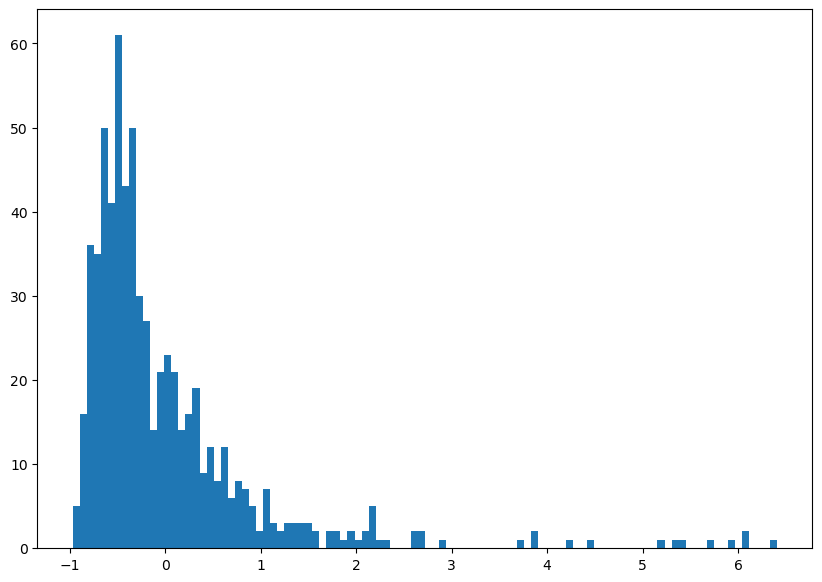

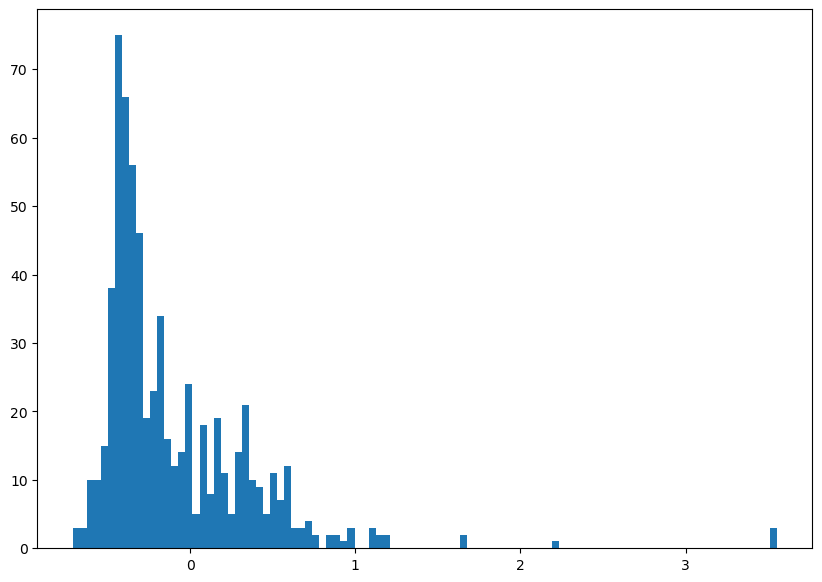

In [436]:
# Find r-squared
y_true = np.squeeze(y_true)
y_preds = np.squeeze(y_preds)

# Plot histograms
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_true, bins = 100)
plt.show()

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_preds, bins = 100)
plt.show()


r2 = pearsonr(y_true, y_preds)[0]

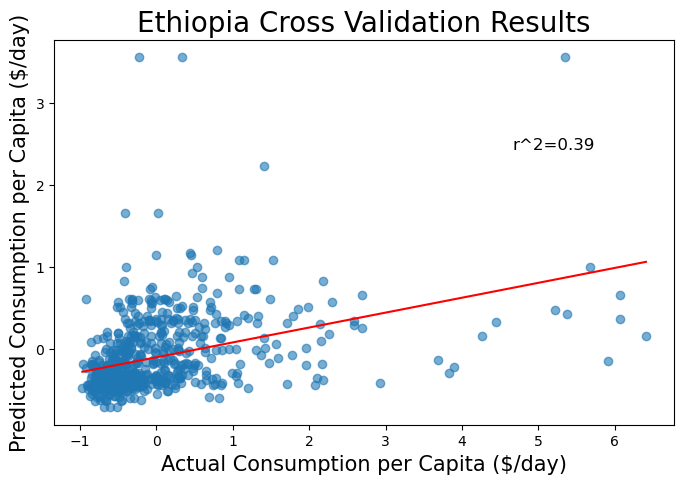

In [437]:
# Plot predictions
country = 'Ethiopia'
fig = plt.figure(figsize=(8,5))
plt.scatter(y_true, y_preds, alpha=0.6)
plt.plot(np.unique(y_true), np.poly1d(np.polyfit(y_true, y_preds, 1))(np.unique(y_true)), color='red')
plt.text(0.5, 0.5, f'r^2={round(r2, 2)}', ha='left', va='top', size=12, transform=ax.transAxes)
plt.xlabel('Actual Consumption per Capita ($/day)', fontsize=15)
plt.ylabel('Predicted Consumption per Capita ($/day)', fontsize=15)
plt.title(f'{country} Cross Validation Results', fontsize=20)
# plt.xlim([np.min(y_true), 10])
# plt.ylim([np.min(y_true), 10])
plt.show()